# Use the 🤗 transformers-native implementation of ColPali

[![Colab](https://img.shields.io/badge/Open_in_Colab-F9AB00?logo=googlecolab&logoColor=fff&style=for-the-badge)](https://colab.research.google.com/github/tonywu71/colpali-cookbooks/blob/main/examples/gen_colpali_similarity_maps.ipynb)
[![GitHub](https://img.shields.io/badge/ColPali_Cookbooks-100000?style=for-the-badge&logo=github&logoColor=white)](https://github.com/tonywu71/colpali-cookbooks)
[![arXiv](https://img.shields.io/badge/arXiv-2407.01449-b31b1b.svg?style=for-the-badge)](https://arxiv.org/abs/2407.01449)
[![Hugging Face](https://img.shields.io/badge/Vidore-FFD21E?style=for-the-badge&logo=huggingface&logoColor=000)](https://huggingface.co/vidore)
[![X](https://img.shields.io/badge/Thread-%23000000?style=for-the-badge&logo=X&logoColor=white)](https://x.com/tonywu_71/status/1809183824464560138)

## Introduction

With our new model *ColPali*, we propose to leverage VLMs to construct efficient multi-vector embeddings in the visual space for document retrieval. Using ColPali removes the need for potentially complex and brittle layout recognition and OCR pipelines with a single model that can take into account both the textual and visual content (layout, charts, ...) of a document. ColPali is also highly interpretable: similarity maps can be obtained between patches and query tokens.

Having integrated ColPali into 🤗 `transformers` ensures seamless maintenance 🔧, standardized interfaces 📚, and compatibility with features like `generate`, `cache`, and `from_pretrained` ✅. Most importantly, this future-proofs the model by automatically supporting new features and updates in the ecosystem. Click on the link below to read the official Hf documentation for ColPali!

[![Hugging Face](https://img.shields.io/badge/ColPali_hf_transformers_documentation-FFD21E?style=for-the-badge&logo=huggingface&logoColor=000)](https://huggingface.co/docs/transformers/main/en/model_doc/colpali)

The following notebook guides you through using the native ColPali model implementation from `transformers` 🤗 for inference, scoring, and interpretability. While there are a few minor differences in the API, all the core functionalities are identical to the original implementation (from `colpali-engine==0.3.x`).


### Hardware Requirements

You can run it on Google Colab (using the free-tier T4 GPU) or locally (tested on a M2 Pro Mac). While Colab already has `transformers` pre-installed, it's recommended to update it to the main branch to make sure you'll have access to the new ColPali model.

In [ ]:
!pip install -q -U huggingface_hub git+https://github.com/huggingface/transformers.git

## Part 1: Run inference with ColPali

### Login to a HuggingFace account

Because ColPali uses the PaliGemma (Gemma-licensed) as its VLM backbone, you will have to login to a HuggingFace account that has accepted the terms and conditions of [`google/paligemma-3b-mix-448`](https://huggingface.co/google/paligemma-3b-mix-448).

In [ ]:
from huggingface_hub import login

login()

### Imports + a few custom utils

In [3]:
from io import BytesIO
from typing import List

import requests
import torch
from IPython.display import display
from PIL import Image
from transformers import ColPaliForRetrieval, ColPaliProcessor


def get_torch_device(device: str = "auto") -> str:
    """
    Returns the device (string) to be used by PyTorch.

    `device` arg defaults to "auto" which will use:
    - "cuda:0" if available
    - else "mps" if available
    - else "cpu".
    """
    if device == "auto":
        if torch.cuda.is_available():
            device = "cuda:0"
        elif torch.backends.mps.is_available():  # for Apple Silicon
            device = "mps"
        else:
            device = "cpu"

    return device


def load_image_from_url(url: str) -> Image.Image:
    """
    Load a PIL image from a valid URL.
    """
    response = requests.get(url)
    return Image.open(BytesIO(response.content))


def scale_image(image: Image.Image, new_height: int = 1024) -> Image.Image:
    """
    Scale an image to a new height while maintaining the aspect ratio.
    """
    # Calculate the scaling factor
    width, height = image.size
    aspect_ratio = width / height
    new_width = int(new_height * aspect_ratio)

    # Resize the image
    scaled_image = image.resize((new_width, new_height))

    return scaled_image

/Users/tony/Desktop/colpali-cookbooks/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the ColPali model and processor

Click on the following link to open the model card for [`vidore/colpali-v1.2-hf`](https://huggingface.co/vidore/colpali-v1.2-hf).

In [4]:
model_name = "vidore/colpali-v1.2-hf"
device = get_torch_device("auto")

print(f"Using device: {device}")

model = ColPaliForRetrieval.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map=device,
).eval()

processor = ColPaliProcessor.from_pretrained(model_name)

Using device: mps


`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.68s/it]


### Image and query inputs

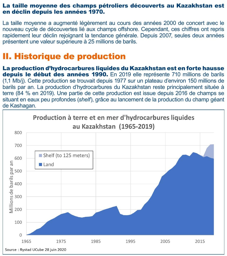

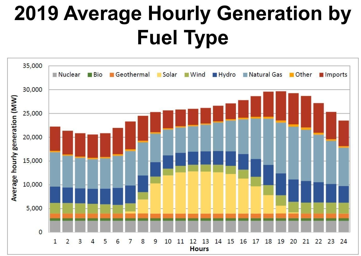

In [5]:
# Load the image and query inputs
images: List[Image.Image] = [
    load_image_from_url(
        "https://github.com/tonywu71/colpali-cookbooks/blob/main/examples/data/shift_kazakhstan.jpg?raw=true"
    ),
    load_image_from_url(
        "https://github.com/tonywu71/colpali-cookbooks/blob/main/examples/data/energy_electricity_generation.jpg?raw=true"
    ),
]

queries: List[str] = [
    "Quelle partie de la production pétrolière du Kazakhstan provient de champs en mer ?",
    "Which hour of the day had the highest overall electricity generation in 2019?",
]

# Preview the input images
for image in images:
    display(scale_image(image, 256))

### Preprocess and embed the queries and the images

In [6]:
# Preprocess inputs
batch_images = processor(images=images).to(model.device)
batch_queries = processor(text=queries).to(model.device)

# Forward pass
with torch.no_grad():
    image_embeddings = model(**batch_images).embeddings
    query_embeddings = model(**batch_queries).embeddings

### Score the queries against the images

With the notebook's default images and queries, you should obtain a score matrix where the maximum scores are on the diagonal. This means the model has retrieved the correct image for each query.

In [7]:
scores = processor.score_retrieval(query_embeddings, image_embeddings)  # (n_queries, n_images)

scores

tensor([[20.6250,  9.7500],
        [11.9375, 16.7500]], dtype=torch.bfloat16)

## Part 2: Generate similarity maps

This section explains how to generate similarity maps between the query and the image. Generating similarity maps with ColPali `transformers 🤗` is almost exactly similar to the `colpali-engine` implementation. Therefore, the following code will be minimal.

For more details on generating similarity maps with ColPali, please refer to my original cookbook on this topic: [ColPali: Generate your own similarity maps 👀](https://colab.research.google.com/github/tonywu71/colpali-cookbooks/blob/main/examples/gen_colpali_similarity_maps.ipynb).

In [ ]:
!pip install -q -U "colpali-engine[interpretability]>=0.3.2,<0.4.0"

### Extra imports

In [9]:
import pprint
from typing import Tuple

import matplotlib.pyplot as plt
from colpali_engine.interpretability import (
    get_similarity_maps_from_embeddings,
    plot_all_similarity_maps,
    plot_similarity_map,
)
from transformers import BatchFeature, ProcessorMixin


def get_n_patches(processor: ProcessorMixin, patch_size: int) -> Tuple[int, int]:
    n_patches_x = processor.image_processor.size["width"] // patch_size
    n_patches_y = processor.image_processor.size["height"] // patch_size
    return n_patches_x, n_patches_y


def get_image_mask(processor: ProcessorMixin, batch_images: BatchFeature) -> torch.Tensor:
    return batch_images.input_ids == processor.image_token_id

### Inputs

To simplify the process, we will use the first query and image from the previous section.

In [10]:
image = images[0]
query = queries[0]
processed_query = processor(text=[query]).to(model.device)

image_embedding = image_embeddings[[0], ...]
query_embedding = query_embeddings[[0], ...]

### Get the per-token similarity maps

In [11]:
# Get the number of patches and the image mask
n_patches = get_n_patches(processor=processor, patch_size=model.vlm.vision_tower.config.patch_size)
image_mask = get_image_mask(processor=processor, batch_images=batch_images)

# Get the similarity maps for the first image in the batch
batched_similarity_maps = get_similarity_maps_from_embeddings(
    image_embeddings=image_embedding,
    query_embeddings=query_embedding,
    n_patches=n_patches,
    image_mask=image_mask,
)
similarity_maps = batched_similarity_maps[0]  # (query_length, n_patches_x, n_patches_y)

# Use this cell output to choose a token using its index
query_content = processor.decode(processed_query.input_ids[0]).replace(processor.tokenizer.pad_token, "")
query_content = query_content.replace(processor.query_augmentation_token, "").strip()
query_tokens = processor.tokenizer.tokenize(query_content)

pprint.pprint({idx: val for idx, val in enumerate(query_tokens)})

{0: '<bos>',
 1: 'Question',
 2: ':',
 3: '▁Quelle',
 4: '▁partie',
 5: '▁de',
 6: '▁la',
 7: '▁production',
 8: '▁p',
 9: 'étro',
 10: 'lière',
 11: '▁du',
 12: '▁Kazakhstan',
 13: '▁provi',
 14: 'ent',
 15: '▁de',
 16: '▁champs',
 17: '▁en',
 18: '▁mer',
 19: '▁?'}


### Select the query token of interest and visualize the associated similarity map

Selected token: `▁Kazakhstan`


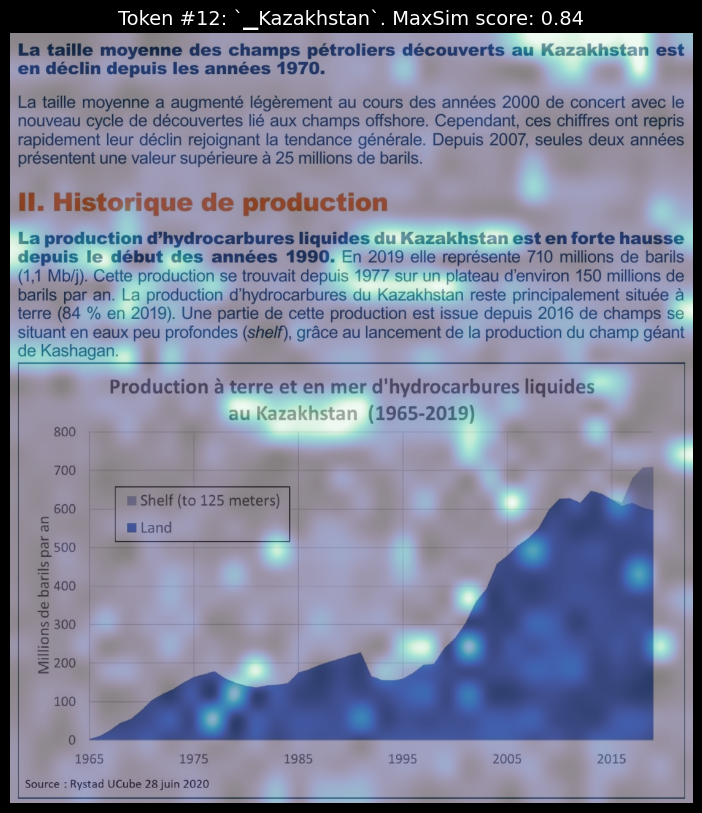

In [13]:
# Choose a token using its index
token_idx = 12  # e.g. if "12: '▁Kazakhstan',", set 12 to choose the token 'Kazakhstan'

print(f"Selected token: `{query_tokens[token_idx]}`")

# Retrieve the similarity map for the chosen token
current_similarity_map = similarity_maps[token_idx]  # (n_patches_x, n_patches_y)

fig, ax = plot_similarity_map(
    image=image,
    similarity_map=current_similarity_map,
    figsize=(8, 8),
    show_colorbar=False,
)

max_sim_score = similarity_maps[token_idx, :, :].max().item()
ax.set_title(f"Token #{token_idx}: `{query_tokens[token_idx]}`. MaxSim score: {max_sim_score:.2f}", fontsize=14)

fig

The brighter the patch, the higher similarity score it has with the selected token. This similarity map exhibits OCR capabilities and chart understanding of ColPali. For instance, the patch containing the selected query token should be clearly highlighted in the similarity map.

### Generate and save similarity maps for all query tokens

You can use the higher-level function `generate_similarity_maps` to generate similarity maps for all query tokens.

In [14]:
plots = plot_all_similarity_maps(
    image=image,
    query_tokens=query_tokens,
    similarity_maps=similarity_maps,
    figsize=(8, 8),
    show_colorbar=False,
    add_title=True,
)

for idx, (fig, ax) in enumerate(plots):
    savepath = f"similarity_map_{idx}.png"
    fig.savefig(savepath, bbox_inches="tight")
    print(f"Similarity map for token `{query_tokens[idx]}` saved at `{savepath}`")

plt.close("all")

/Users/tony/Desktop/colpali-cookbooks/.venv/lib/python3.10/site-packages/colpali_engine/interpretability/similarity_maps.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)


Similarity map for token `<bos>` saved at `similarity_map_0.png`
Similarity map for token `Question` saved at `similarity_map_1.png`
Similarity map for token `:` saved at `similarity_map_2.png`
Similarity map for token `▁Quelle` saved at `similarity_map_3.png`
Similarity map for token `▁partie` saved at `similarity_map_4.png`
Similarity map for token `▁de` saved at `similarity_map_5.png`
Similarity map for token `▁la` saved at `similarity_map_6.png`
Similarity map for token `▁production` saved at `similarity_map_7.png`
Similarity map for token `▁p` saved at `similarity_map_8.png`
Similarity map for token `étro` saved at `similarity_map_9.png`
Similarity map for token `lière` saved at `similarity_map_10.png`
Similarity map for token `▁du` saved at `similarity_map_11.png`
Similarity map for token `▁Kazakhstan` saved at `similarity_map_12.png`
Similarity map for token `▁provi` saved at `similarity_map_13.png`
Similarity map for token `ent` saved at `similarity_map_14.png`
Similarity map f